##    第1章　API周りの初期設定
---



**はじめに[Kaggle](https://www.kaggle.com/)のアカウントからAPIを使うためにjson持ってきて入れましょう**

In [0]:
from google.colab import files
files.upload()

**jsonを入れれたらcolab上で使えるように権限を変えましょう**

In [96]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls -l /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

total 4
-rw------- 1 root root 62 Oct 31 06:53 kaggle.json


**これでKaggleのAPIが使えるようになったので、早速 train/test データをダウンロードしましょう**

In [0]:
!kaggle competitions download -c titanic

## 第2章　ライブラリの追加

---



今回はNNの定義にkerasを使うのでKerasを入れます。後は予測データを直接kaggleにアップするのでkaggleも入れます。

In [0]:
!pip install kaggle
!pip install keras

## 第3章　実際にやってみる
---

**最初にライブラリをインポートしましょう**

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from subprocess import check_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.utils import np_utils
from keras.optimizers import SGD

**データをpandasで読み込み、少しだけ表示します。先程ダウンロードしたtrain / test データは content下にあります。**

In [50]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**12次元のデータの中から、必要そうなラベルだけ取り出します**

今回はチケットのクラス、性別、年齢、運賃を使用しました(cabinは欠損値多そう) 

In [87]:
print('train size: ',df_train.shape,'\nlabel cate:',df_train.columns.values)
features = ['Pclass','Sex','Age','Fare']

train size:  (891, 12) 
label cate: ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


**データを整形します。使わないですが、チケットは特に綺麗ではないです**

In [88]:
le = LabelEncoder()

df_train["Sex"] = le.fit_transform(df_train["Sex"])
df_test["Sex"] =  le.fit_transform(df_test["Sex"])

df_train['Fare'] = df_train['Fare'].fillna(df_train['Fare'].mean())
df_test['Fare'] = df_train['Fare'].fillna(df_train['Fare'].mean())

df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean())
df_test['Age'] = df_train['Age'].fillna(df_train['Age'].mean())

df_train['Embarked'] = df_train['Embarked'].fillna("S")
df_test['Embarked'] = df_test['Embarked'].fillna("S")

df_train['Embarked'] = le.fit_transform(df_train['Embarked'])
df_test['Embarked'] = le.fit_transform(df_test['Embarked'])

df_train['Cabin'] = df_train['Cabin'].fillna("None")
df_test['Cabin'] = df_test['Cabin'].fillna("None")
df_train['Cabin'] = le.fit_transform(df_train['Cabin'])
df_test['Cabin'] = le.fit_transform(df_test['Cabin'])

df_train['Ticket'] = le.fit_transform(df_train['Ticket'])
df_test['Ticket'] = le.fit_transform(df_test['Ticket'])



y = df_train['Survived']
x = df_train[features]
x_t = df_test[features]
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,523,7.2500,146,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,596,71.2833,81,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,669,7.9250,146,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,49,53.1000,55,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,472,8.0500,146,2


**train / test データの設定・確認　**

今回はデータ数が少ないのでvalidationは無し

In [89]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10,random_state=32)
print("X_train :",X_train.shape)
print("X_test :",X_test.shape)
print("y_train :",y_train.shape)
print("y_test :",y_test.shape)

X_train : (801, 4)
X_test : (90, 4)
y_train : (801,)
y_test : (90,)


**モデルの設定 **

今回は畳み込みの方法がわからないので全結合

In [90]:
model = Sequential()

model.add(Dense(64,input_dim=len(features)))
model.add(Activation("relu"))
model.add(Dropout(0.3))

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.3))

model.add(Dense(2))
model.add(Activation("softmax"))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                320       
_________________________________________________________________
activation_16 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_17 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 130       
__________

**学習はじめます**

とりあえず1000epoch

In [91]:
y_train_categorical = np_utils.to_categorical(y_train)
history = model.fit(X_train.values, y_train_categorical, nb_epoch=1000)

/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1000
801/801 [==============================] - 0s 559us/step - loss: 1.9617 - acc: 0.5868
Epoch 2/1000
801/801 [==============================] - 0s 63us/step - loss: 1.5616 - acc: 0.5768
Epoch 3/1000
801/801 [==============================] - 0s 59us/step - loss: 1.3431 - acc: 0.5780
Epoch 4/1000
801/801 [==============================] - 0s 58us/step - loss: 1.1595 - acc: 0.5918
Epoch 5/1000
801/801 [==============================] - 0s 59us/step - loss: 1.0444 - acc: 0.5955
Epoch 6/1000
801/801 [==============================] - 0s 65us/step - loss: 0.9290 - acc: 0.5980
Epoch 7/1000
801/801 [==============================] - 0s 62us/step - loss: 0.8577 - acc: 0.6130
Epoch 8/1000
801/801 [==============================] - 0s 57us/step - loss: 0.8217 - acc: 0.6080
Epoch 9/1000
801/801 [==============================] - 0s 60us/step - loss: 0.8157 - acc: 0.5943
Epoch 10/1000
801/801 [==============================] - 0s 61us/step - loss: 0.7435 - acc: 0.6442
Epoch 11/1000
801/

**acc / lossをグラフにプロットしてみる**

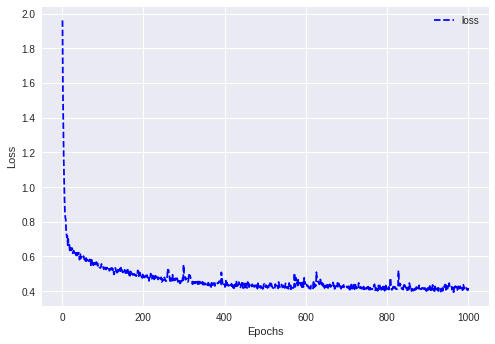

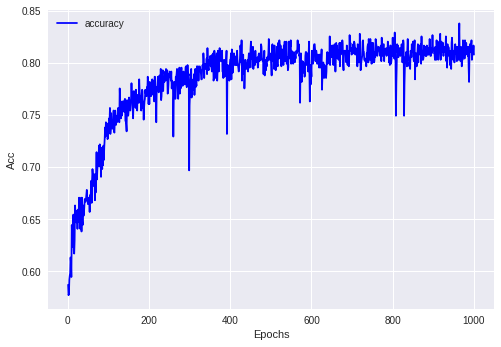

In [92]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, '--b', label='loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.clf()

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc,'b', label='accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

**テストデータに試してみる**

In [93]:
y_test_categorical = np_utils.to_categorical(y_test)
loss_and_metrics = model.evaluate(X_test.values, y_test_categorical)
classes = model.predict_classes(x_t.values)

print(loss_and_metrics)

90/90 [==============================] - 0s 1ms/step
[0.4342318038145701, 0.8666666600439283]


## 第4章　提出してみる


---


In [95]:
submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": classes})
print(submission[0:10])

submission.to_csv('./titanic_submission.csv', index=False)

# submit the file to kaggle
!kaggle competitions submit titanic -f titanic_submission.csv -m "-Cabin !"

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         0
7          899         1
8          900         1
9          901         0
100% 2.77k/2.77k [00:01<00:00, 2.58kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster